In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

from datetime import datetime
from scipy import stats

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from mlxtend.feature_selection import ColumnSelector
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler, Normalizer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

## 线下用户特征

在模型的训练中，不再使用User_id，因为User_id不带有任何信息，我们需要从各种信息中获取信息来刻画一个User_id

用户领取优惠券并核销信息

已经实现

+ 用户领取优惠券次数
+ 用户获得优惠券并核销次数
+ 用户领取优惠券后进行核销率
+ 用户领取不同商户优惠券的次数
+ 用户核销不同商户优惠券的次数
+ 用户领取不同优惠券的数量
+ 用户核销不同优惠券的数量
+ 用户领取不同类型的优惠券数量
+ 用户核销不同类型的优惠券数量
+ 用户领取不同距离的商户数量
+ 用户核销不同距离的商户数量
+ 用户核销过优惠券的不同商家数量，及其占所有不同商家的比重
+ 用户核销过的不同优惠券数量，及其占所有不同优惠券的比重
+ 用户平均核销每个商家多少张优惠券
+ 用户核销优惠券的平均/最低/最高消费折率
+ 用户核销优惠券中的平均/最大/最小用户-商家距离

未实现

+ 用户满200/200~500 减的优惠券核销率
+ 用户核销满200/200~500减的优惠券占所有核销优惠券的比重

In [2]:
base_features_df = pd.read_csv('../features/lcm_base_features.csv')

In [3]:
base_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1053282 entries, 0 to 1053281
Data columns (total 14 columns):
User_id              1053282 non-null int64
Merchant_id          1053282 non-null float64
Coupon_id            1053282 non-null float64
Distance             1053282 non-null float64
Date_received        1053282 non-null float64
Is_in_day_consume    1053282 non-null float64
Discount             1053282 non-null float64
Base_consume         1053282 non-null float64
Discount_money       1053282 non-null float64
Day_in_month         1053282 non-null float64
Day_in_week          1053282 non-null float64
Coupon_type          1053282 non-null float64
Offline_consume      1053282 non-null float64
Duration             1053282 non-null float64
dtypes: float64(13), int64(1)
memory usage: 112.5 MB


In [4]:
# df = base_features_df[base_features_df['Date_received']< 20160501]
df = base_features_df.copy()

In [5]:
def join(df, col, series, key):
    return multi_join(df, col, series, [key])

def multi_join(df, col, series, keys):
    t = series.to_frame()
    t.columns = [col]
    
    return pd.merge(df, t, on=keys, how='left')

In [6]:
def receive_count(df, target, groupby, is_dup=True):
    if is_dup:
        return df[df['Date_received']>0][target].drop_duplicates().groupby(groupby).size()
    else:
        return df[df['Date_received']>0][target].groupby(groupby).size()

def cousume_count(df, target, groupby, is_dup=True):
    if is_dup:
        return df[df['Offline_consume']>0][target].drop_duplicates().groupby(groupby).size()
    else:
        return df[df['Offline_consume']>0][target].groupby(groupby).size()

def used_count(df, target, groupby, is_dup=True):
    if is_dup:
        return df[df['Is_in_day_consume']>0][target].drop_duplicates().groupby(groupby).size()
    else:
        return df[df['Is_in_day_consume']>0][target].groupby(groupby).size()

def cal_user_used_coupon_rate(row):
    return row.User_used_count/row.User_receive_count

def cal_user_not_used_conpon_count(row):
    return row.User_receive_count - row.User_used_count

def extract_info(df, target, type, groupby, column_name, is_dup=True):
    factory = {
        'receive_type': receive_count,
        'used_type': used_count
    }
    
    target_df = df[groupby].drop_duplicates()
    series = factory[type](df, target, groupby, is_dup)
    
    tdf = multi_join(target_df, column_name, series, groupby)
    tdf = tdf.fillna(0)
    
    mean = tdf[column_name].mean()
    tdf[column_name+'_occ'] = tdf[column_name] / mean
    return tdf[groupby + [column_name, column_name+'_occ']]

In [7]:
class GroupbyExtractor(TransformerMixin):
    def __init__(self, fn, target, type, groupby, column_name):
        self.fn = fn
        self.target = target
        self.type = type
        self.groupby = groupby
        self.column_name = column_name
    
    def fit(self, *args, **kwargs):
        return self

    def transform(self, X, **transform_params):
        return self.fn(X, self.target, self.type, self.groupby, self.column_name)

In [8]:
keys = ['User_id']
user_features_df = df[['User_id']].drop_duplicates()

user_features_df = pd.merge(user_features_df, extract_info(df, ['User_id'], 'receive_type', ['User_id'], 'User_receive_count', False), on=keys, how='left')
user_features_df = pd.merge(user_features_df, extract_info(df, ['User_id'], 'used_type', ['User_id'], 'User_used_count', False), on=keys, how='left')
user_features_df = pd.merge(user_features_df, extract_info(df, ['User_id', 'Merchant_id'], 'receive_type', ['User_id'], 'User_receive_diff_merchant_count'), on=keys, how='left')
user_features_df = pd.merge(user_features_df, extract_info(df, ['User_id', 'Merchant_id'], 'used_type', ['User_id'], 'User_used_diff_merchant_count'), on=keys, how='left')
user_features_df = pd.merge(user_features_df, extract_info(df, ['User_id', 'Coupon_id'], 'receive_type', ['User_id'], 'User_receive_diff_coupon_count'), on=keys, how='left')
user_features_df = pd.merge(user_features_df, extract_info(df, ['User_id', 'Coupon_id'], 'used_type', ['User_id'], 'User_used_diff_coupon_count'), on=keys, how='left')

for i in range(0, 2, 1):
    
    user_features_df = pd.merge(
        user_features_df, 
        extract_info(
            df[df['Coupon_type'] == i], 
            ['User_id', 'Coupon_type'], 
            'receive_type', ['User_id'], 
            'User_receive_coupon_type_%s_count' % (i),
            False
        ), 
        on=keys, how='left'
    )
    
    user_features_df = pd.merge(
        user_features_df, 
        extract_info(
            df[df['Coupon_type'] == i], 
            ['User_id', 'Coupon_type'], 
            'used_type', 
            ['User_id'], 
            'User_used_coupon_type_%s_count' % (i),
            False
        ), on=keys, how='left')
    
    user_features_df['User_used_coupon_type_%s_rate' % (i)] = user_features_df['User_used_coupon_type_%s_count' % (i)] / user_features_df['User_used_count']

for i in range(0, 11, 1):
    
    user_features_df = pd.merge(
        user_features_df, 
        extract_info(
            df[df['Distance'] == i], 
            ['User_id', 'Distance'], 
            'receive_type', 
            ['User_id'], 
            'User_receive_distance_%s_count' % (i),
            False
        ), 
        on=keys, how='left'
    )
    
    user_features_df = pd.merge(
        user_features_df, 
        extract_info(
            df[df['Distance'] == i], 
            ['User_id', 'Distance'], 
            'used_type', 
            ['User_id'], 
            'User_used_distance_%s_count' % (i),
            False
        ), on=keys, how='left')
    
    user_features_df['User_used_distance_%s_rate' % (i)] = user_features_df['User_used_distance_%s_count' % (i)] / user_features_df['User_used_count']
    

user_features_df['User_used_rate'] = user_features_df['User_used_count'] / user_features_df['User_receive_count']

merchant_count = df['Merchant_id'].unique().size
user_features_df['User_receive_diff_merchant_rate'] = user_features_df['User_receive_diff_merchant_count'] / merchant_count
user_features_df['User_used_diff_merchant_rate'] = user_features_df['User_used_diff_merchant_count'] / merchant_count

coupon_count = df['Coupon_id'].unique().size
user_features_df['User_receive_diff_coupon_rate'] = user_features_df['User_receive_diff_coupon_count'] / coupon_count
user_features_df['User_used_diff_coupon_rate'] = user_features_df['User_used_diff_coupon_count'] / coupon_count

user_features_df['User_used_mean_4_merchant'] = user_features_df['User_used_count'] / user_features_df['User_used_diff_merchant_count']

user_features_df = user_features_df.fillna(0)
user_features_df['User_used_rate_occ'] = user_features_df['User_used_rate'] / user_features_df['User_used_rate'].mean()

In [9]:
t = base_features_df[['User_id', 'Discount']].groupby('User_id').agg(['mean', 'max', 'min'])
t.columns = ["_User_".join(x) for x in t.columns.ravel()]
user_features_df = pd.merge(user_features_df, t, on=keys, how='left')

In [10]:
t = base_features_df[['User_id', 'Distance']].groupby('User_id').agg(['mean', 'max', 'min'])
t.columns = ["_User_".join(x) for x in t.columns.ravel()]
user_features_df = pd.merge(user_features_df, t, on=keys, how='left')

In [11]:
user_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510698 entries, 0 to 510697
Data columns (total 91 columns):
User_id                                 510698 non-null int64
User_receive_count                      510698 non-null int64
User_receive_count_occ                  510698 non-null float64
User_used_count                         510698 non-null float64
User_used_count_occ                     510698 non-null float64
User_receive_diff_merchant_count        510698 non-null int64
User_receive_diff_merchant_count_occ    510698 non-null float64
User_used_diff_merchant_count           510698 non-null float64
User_used_diff_merchant_count_occ       510698 non-null float64
User_receive_diff_coupon_count          510698 non-null int64
User_receive_diff_coupon_count_occ      510698 non-null float64
User_used_diff_coupon_count             510698 non-null float64
User_used_diff_coupon_count_occ         510698 non-null float64
User_receive_coupon_type_0_count        510698 non-null float64
U

In [12]:
user_features_df.columns.values

array(['User_id', 'User_receive_count', 'User_receive_count_occ',
       'User_used_count', 'User_used_count_occ',
       'User_receive_diff_merchant_count',
       'User_receive_diff_merchant_count_occ',
       'User_used_diff_merchant_count',
       'User_used_diff_merchant_count_occ',
       'User_receive_diff_coupon_count',
       'User_receive_diff_coupon_count_occ',
       'User_used_diff_coupon_count', 'User_used_diff_coupon_count_occ',
       'User_receive_coupon_type_0_count',
       'User_receive_coupon_type_0_count_occ',
       'User_used_coupon_type_0_count',
       'User_used_coupon_type_0_count_occ',
       'User_used_coupon_type_0_rate', 'User_receive_coupon_type_1_count',
       'User_receive_coupon_type_1_count_occ',
       'User_used_coupon_type_1_count',
       'User_used_coupon_type_1_count_occ',
       'User_used_coupon_type_1_rate', 'User_receive_distance_0_count',
       'User_receive_distance_0_count_occ', 'User_used_distance_0_count',
       'User_used_distance

In [13]:
user_features_df.head(20)

,User_id,User_receive_count,User_receive_count_occ,User_used_count,User_used_count_occ,User_receive_diff_merchant_count,User_receive_diff_merchant_count_occ,User_used_diff_merchant_count,User_used_diff_merchant_count_occ,User_receive_diff_coupon_count,...,User_receive_diff_coupon_rate,User_used_diff_coupon_rate,User_used_mean_4_merchant,User_used_rate_occ,Discount_User_mean,Discount_User_max,Discount_User_min,Distance_User_mean,Distance_User_max,Distance_User_min
0,1439408,5,2.424318,0.0,0.000000,2,1.192558,0.0,0.00000,3,...,0.000308,0.000000,0.0,0.000000,0.933333,0.950000,0.866667,0.200000,1.0,0.0
1,1832624,1,0.484864,0.0,0.000000,1,0.596279,0.0,0.00000,1,...,0.000103,0.000000,0.0,0.000000,0.900000,0.900000,0.900000,0.000000,0.0,0.0
2,2029232,3,1.454591,0.0,0.000000,3,1.788837,0.0,0.00000,3,...,0.000308,0.000000,0.0,0.000000,0.894444,0.950000,0.833333,0.333333,1.0,0.0
3,2747744,1,0.484864,0.0,0.000000,1,0.596279,0.0,0.00000,1,...,0.000103,0.000000,0.0,0.000000,0.800000,0.800000,0.800000,-1.000000,-1.0,-1.0
4,196342,1,0.484864,0.0,0.000000,1,0.596279,0.0,0.00000,1,...,0.000103,0.000000,0.0,0.000000,0.950000,0.950000,0.950000,1.000000,1.0,1.0
5,2223968,1,0.484864,0.0,0.000000,1,0.596279,0.0,0.00000,1,...,0.000103,0.000000,0.0,0.000000,0.500000,0.500000,0.500000,2.000000,2.0,2.0
6,73611,1,0.484864,0.0,0.000000,1,0.596279,0.0,0.00000,1,...,0.000103,0.000000,0.0,0.000000,0.900000,0.900000,0.900000,-1.000000,-1.0,-1.0
7,163606,1,0.484864,0.0,0.000000,1,0.596279,0.0,0.00000,1,...,0.000103,0.000000,0.0,0.000000,0.850000,0.850000,0.850000,10.000000,10.0,10.0
8,3273056,1,0.484864,0.0,0.000000,1,0.596279,0.0,0.00000,1,...,0.000103,0.000000,0.0,0.000000,0.900000,0.900000,0.900000,10.000000,10.0,10.0
9,94107,1,0.484864,0.0,0.000000,1,0.596279,0.0,0.00000,1,...,0.000103,0.000000,0.0,0.000000,0.900000,0.900000,0.900000,2.000000,2.0,2.0


In [14]:
user_features_df.to_csv('../features/lcm_user_features.csv', index=False, header=True)

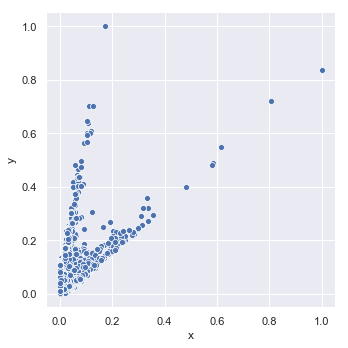

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

user_features_df = pd.read_csv('../features/lcm_user_features.csv')
user_features_df = user_features_df.drop(['User_id'], axis=1)

user_features_pipe = Pipeline([
    ('pca', PCA(n_components=2)),
    ('scale', MinMaxScaler()),
])

user_features_pipe.fit(user_features_df)
output = user_features_pipe.transform(user_features_df)

output_df = pd.DataFrame(data=output, columns=['x', 'y'])

sns.relplot(x="x", y="y", data=output_df);